# PCM development notebook

The aim of this notebook is to create a PCM model and train it with a dataset. Some figures that could help to PCM model development are also plotted.
__TODO__: explain more (pyxpcm, where to find some exemples of models or datasets) and logos 

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1600874641188_caribe.nc'
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'

Variables names in dataset (__TODO__: find an elegant way to do that)

In [3]:
# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
lat_dim = 'latitude'
z_dim = 'depth'
var_name = 'thetao' #temp_var = 'fe'

__Model options__

In [4]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z} #pcm_features = {'iron': z}
# {variable name in model: variable name in dataset}
features_in_ds = {'temperature': var_name}

# number of classes
K=6

__Plot options__

## Load training dataset
***

In [5]:
ds = xr.open_dataset(file_path)

#some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'

ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 205, longitude: 577, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -5274.784 -5727.917
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 46.916668 47.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -6.0 -5.9166665 -5.8333335 ... 41.916668 42.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Quick plot of dataset

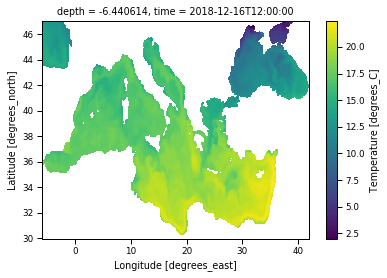

In [6]:
ds[var_name].isel(time=11, depth=5).plot();

## Create and train model
***

### Create PCM

In [7]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [8]:
m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 42.685806

## Development plots
***

__Scatter plot of features, as seen by the classifier__

__TODO__: Plot only first dimension for each feature

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim=z_dim)

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, kde=True, dim=z_dim)

__Mask__

In [ ]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

__BIC__

In [ ]:
#### using all dataset

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(dsp, features=features_in_ds, dim=z_dim)
        #calculate BIC
        BIC[k,run] = m.bic(dsp, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7


In [13]:
#### using random lat and lon

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)
#choose random sample of dataset
n_lat = np.int(dsp.latitude.size/2)
n_lon = np.int(dsp.longitude.size/2)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #random sample
        i_lat = np.random.choice(range(dsp.latitude.size), n_lat, replace=False)
        i_lon = np.random.choice(range(dsp.longitude.size), n_lon, replace=False)
        ds_ran = dsp.isel(latitude=i_lat, longitude=i_lon)
        
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(ds_ran, features=features_in_ds, dim=z_dim)
        
        #calculate BIC
        BIC[k,run] = m.bic(ds_ran, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7
8
9
32.546553234259285


In [19]:
#### using only profiles not touching

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))
grid_dist = 6

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #random sample
        latp = np.random.choice(range(dsp.latitude.size), 1, replace=False)
        lonp = np.random.choice(range(dsp.latitude.size), 1, replace=False)
        i_lat = np.concatenate((np.arange(0,latp,grid_dist),np.arange(latp,dsp.latitude.size,grid_dist)))
        i_lon = np.concatenate((np.arange(0,lonp,grid_dist),np.arange(lonp,dsp.longitude.size,grid_dist)))
        #print(i_lat)
        #print(i_lon)
        ds_ran = dsp.isel(latitude=i_lat, longitude=i_lon)
        
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(ds_ran, features=features_in_ds, dim=z_dim)
        #calculate BIC
        BIC[k,run] = m.bic(ds_ran, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7
8
9
3.8195624073346455


In [42]:
#function remapping grid using start point and grid extent

def mapping_corr_dist(coor_dist, start_point, grid_extent):

    # angular distance d/earth's radius (km)
    delta = coor_dist/6371
    
    # all in radians (conversion at the end)
    grid_extent = grid_extent*np.pi/180
    start_point = start_point*np.pi/180
    
    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi/2 
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) + np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

        
    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi/2 
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) - np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2
    
    new_lats = np.sort(new_lats)*180/np.pi
    
    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    new_lons = np.sort(new_lons)*180/np.pi
    
    return new_lats, new_lons

In [43]:
start_point = np.array([ds.longitude[100], ds.latitude[100]])
grid_extent = np.array([ds.longitude.values.min(), ds.longitude.values.max(), ds.latitude.values.min(), ds.latitude.values.max()])
new_lats, new_lons = mapping_corr_dist(coor_dist=100, start_point=start_point, grid_extent=grid_extent)

In [40]:
np.concatenate((lonp,latp))

array([13.66666698, 45.66666794])

In [48]:
#### correlation distance as input

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)

# grid extent
grid_extent = np.array([dsp.longitude.values.min(), dsp.longitude.values.max(), dsp.latitude.values.min(), dsp.latitude.values.max()])

#choose spatial correlation (km)
corr_dist = 30

#calculate number of profiles

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #random fist point
        latp = np.random.choice(dsp.latitude.values, 1, replace=False)
        lonp = np.random.choice(dsp.longitude.values, 1, replace=False)
        #mapping
        new_lats, new_lons = mapping_corr_dist(coor_dist=corr_dist, start_point=np.concatenate((lonp,latp)), grid_extent=grid_extent)
        print(len(new_lats)*len(new_lons))
        ds_ran = dsp.sel(latitude=list(new_lats), longitude=list(new_lons), method='nearest')
        
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(ds_ran, features=features_in_ds, dim=z_dim)
        #calculate BIC
        BIC[k,run] = m.bic(ds_ran, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
8710
8320
9425
8970
9295
10140
9360
8450
9295
8515
9750
9750
8320
9360
9490
8970
8775
9295
8255
8645
1
10140
9880
9880
10010
9230
9165
9815
8710
10075
9100
8450
8970
9620
8190
9815
8060
8255
9880
8580
9880
2
8905
8320
10075
8450
9295
8775
8385
9165
9945
8645
10075
9100
8060
8970
9425
9815
8385
9685
8450
9230
3
9750
9295
8515
8840
8580
8970
10010
9100
8970
9880
9360
8710
8645
9880
9620
8580
8645
8450
8385
9620
4
9100
9945
9555
8710
9100
9295
9425
8255
9750
8905
8060
10010
9295
8190
8910
8840
8190
8840
9230
8515
5
9035
10075
9100
8515
9165
8840
8840
8905
9815
10010
8775
8320
9165
10010
9685
8450
8580
9035
8450
9165
6
9035
8710
9295
9555
9945
9100
8255
9165
9100
9880
8645
9230
8255
9750
9295
8645
9880
9360
8840
9230
7
8970
9230
9295
8840
8450
9880
8125
10010
9702
10140
9880
8450
9035
8060
8060
9880
9685
9100
8255
10140
8
9230
9945
9636
9490
8320
8710
9425
8125
9620
9815
8255
9620
8905
8320
9360
9165
8190
9425
8710
8580
9
8320
10140
8775
8450
8320
9945
9360
8125
9165
8905
9295
8450
9815


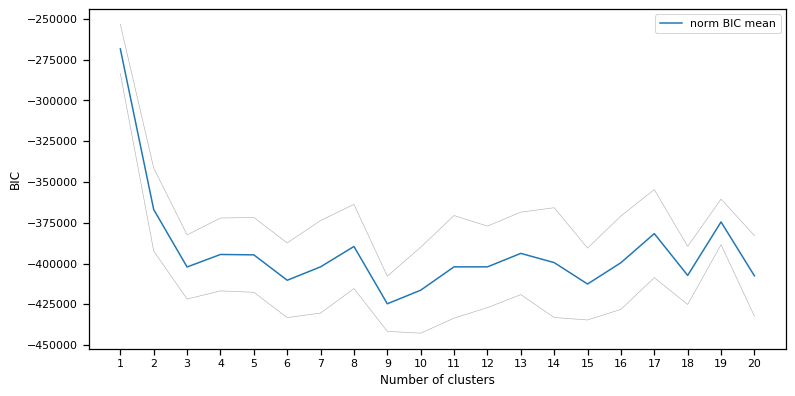

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(kmax)+1,BICmean,label='norm BIC mean')
plt.plot(np.arange(kmax)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(kmax)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(kmax)+1)
plt.legend()

__Robustness__

Description

In [ ]:
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

In [ ]:
P = Plotter(ds, m)
P.plot_robustness(time_slice=7)

## Save fitted model
***

In [ ]:
# save model to development
#m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')